In [19]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras import Model
from keras import Input
from keras.utils import plot_model
from keras.layers import concatenate
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras import backend as K

from sklearn.preprocessing import OneHotEncoder

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import scipy.io as sio
import os

%matplotlib inline

In [20]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
imgloc_train = []
label_train = []

imgloc_val = []
label_val = []

for dirname, _, filenames in os.walk('/content/drive/My Drive/Project Data/Train/Adults'):
    for filename in filenames[:-50]:
        imgloc_train.append((os.path.join(dirname, filename)))
        label_train.append(0)
    for filename in filenames[-50:]:
        imgloc_val.append((os.path.join(dirname, filename)))
        label_val.append(0)
        
for dirname, _, filenames in os.walk('/content/drive/My Drive/Project Data/Train/Teenagers'):
    for filename in filenames[:-50]:
        imgloc_train.append((os.path.join(dirname, filename)))
        label_train.append(1)
    for filename in filenames[-50:]:
        imgloc_val.append((os.path.join(dirname, filename)))
        label_val.append(1)
        
for dirname, _, filenames in os.walk('/content/drive/My Drive/Project Data/Train/Toddler'):
    for filename in filenames[:-50]:
        imgloc_train.append((os.path.join(dirname, filename)))
        label_train.append(2)
    for filename in filenames[-50:]:
        imgloc_val.append((os.path.join(dirname, filename)))
        label_val.append(2)

In [22]:
img_train = []
img_val = []

for i in range(0, len(imgloc_train)):
    img1 = cv2.imread(imgloc_train[i],1)
    img2 = np.array(img1)
    img2 = cv2.resize(img2,(128,128))
    img_train.append(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))
    
for i in range(0, len(imgloc_val)):
    img1 = cv2.imread(imgloc_val[i],1)
    img2 = np.array(img1)
    img2 = cv2.resize(img2,(128,128))
    img_val.append(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))

In [23]:
img_train = np.array(img_train)
label_train = np.array(label_train).reshape(-1,1)

img_val = np.array(img_val)
label_val = np.array(label_val).reshape(-1,1)

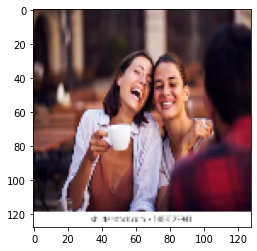

In [24]:
i = 5
plt.imshow(img_train[i])
plt.imshow(img_val[i])

In [25]:
img_train.shape

(2439, 128, 128, 3)

In [26]:
x_train = img_train/255
x_val = img_val/255

In [27]:
enc_y = OneHotEncoder(handle_unknown='ignore')
enc_y.fit(label_train)
y_train = enc_y.transform(label_train).toarray()
y_val = enc_y.transform(label_val).toarray()

In [28]:
x_train.shape

(2439, 128, 128, 3)

In [29]:
y_train.shape

(2439, 3)

In [63]:
reg = l2(1e-2)

model = Sequential()
model.add(Conv2D(6, kernel_size = (5, 5), strides = (1, 1), activation = 'relu', input_shape = x_train[0].shape,
                 kernel_regularizer = reg))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Conv2D(16, kernel_size = (5, 5), strides = (1, 1), activation = 'relu', kernel_regularizer = reg))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Conv2D(32, kernel_size = (5, 5), strides = (1, 1), activation = 'relu', kernel_regularizer = reg))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu', kernel_regularizer = reg))
model.add(Dense(256, activation = 'relu', kernel_regularizer = reg))
model.add(Dense(3, activation = 'softmax', kernel_regularizer = reg))

# model.load_weights('LeNet.h5')

In [64]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 124, 124, 6)       456       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 58, 58, 16)        2416      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 29, 29, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 32)        12832     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)             

In [65]:
adam = Adam(learning_rate = 0.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics = ['categorical_accuracy'])

In [67]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('LeNet-Reg-loss-colab.h5', monitor='loss', mode='min', save_best_only=True, verbose=1)
callbacks = [es, mc]

history = model.fit(
    x = x_train,
    y = y_train,
    epochs=500, batch_size=32,
    validation_data = (x_val,y_val),
    verbose = 1, callbacks = callbacks)

Epoch 1/500
74/77 [===========================>..] - ETA: 0s - loss: 17.8070 - categorical_accuracy: 0.3708
Epoch 00001: loss improved from inf to 17.68647, saving model to LeNet-Reg-loss-colab.h5
77/77 [==============================] - 2s 25ms/step - loss: 17.6865 - categorical_accuracy: 0.3723 - val_loss: 13.4639 - val_categorical_accuracy: 0.3333
Epoch 2/500
76/77 [============================>.] - ETA: 0s - loss: 10.6745 - categorical_accuracy: 0.3840
Epoch 00002: loss improved from 17.68647 to 10.66776, saving model to LeNet-Reg-loss-colab.h5
77/77 [==============================] - 2s 23ms/step - loss: 10.6678 - categorical_accuracy: 0.3842 - val_loss: 8.2647 - val_categorical_accuracy: 0.4267
Epoch 3/500
76/77 [============================>.] - ETA: 0s - loss: 6.7259 - categorical_accuracy: 0.4104
Epoch 00003: loss improved from 10.66776 to 6.72218, saving model to LeNet-Reg-loss-colab.h5
77/77 [==============================] - 2s 21ms/step - loss: 6.7222 - categorical_accurac

In [69]:
model = load_model('LeNet-Reg-loss-colab.h5')

In [ ]:
model.save('/content/drive/My Drive/Project Data/LeNet-Reg-loss-colab.h5')

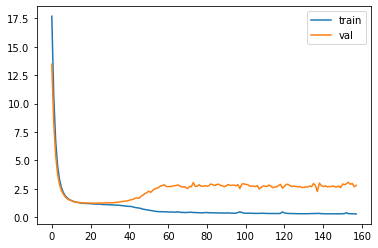

In [70]:
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

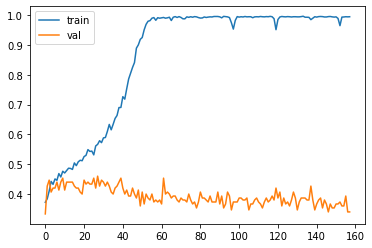

In [71]:
plt.figure()
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='val')
plt.legend()
plt.show()

In [72]:
#loss 0.92
#acc 0.57
model.evaluate(x_train,y_train)

77/77 [==============================] - 1s 9ms/step - loss: 0.2756 - categorical_accuracy: 0.9963


[0.27555593848228455, 0.9963099360466003]

In [73]:
ymodel = model.predict(x_val)
ymodel = enc_y.inverse_transform(ymodel)

In [74]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support

In [75]:
confusion_matrix(label_val,ymodel)

array([[10, 24, 16],
       [18, 14, 18],
       [ 3, 16, 31]])

In [76]:
f1_score(label_val,ymodel,average='weighted')

0.35175826142009714

In [77]:
precision_recall_fscore_support(label_val,ymodel)

(array([0.32258065, 0.25925926, 0.47692308]),
 array([0.2 , 0.28, 0.62]),
 array([0.24691358, 0.26923077, 0.53913043]),
 array([50, 50, 50]))